# Classification POC

This notebook will describe the process of face recognition using `elasticsearch` and `deepface` package.

## Roadamp

1. Face Detection
2. Embeddings generation
3. Data Saving
4. Passport Query

## Environment Setup

In [7]:
import os
from typing import Final

WORKDIR_PATH: Final[str] = 'classification_poc'
PASSPORTS_FOLDER_PATH: Final[str] = os.path.join(WORKDIR_PATH, 'passports')
TEST_IMAGES_FOLDER_PATH: Final[str] = os.path.join(WORKDIR_PATH, 'test_images')

## 1. Face Detection

### Imports

In [8]:
from deepface import DeepFace
import os

### Detecting faces

In [9]:
def detect_faces(image_path: str) -> list[dict]:
    """
        This function detectes the faces of a given image
        Args:
            image_path: str - Path to the image on the disk
        Returns:
            List of the faces detected in the given image alongside some metadata
    """
    assert os.path.exists(image_path), 'Can not detect faces of image that does not exist'

    backends: list = [
      'opencv', 
      'ssd', 
      'dlib', 
      'mtcnn', 
      'retinaface', 
      'mediapipe'
    ]

    face_locations = DeepFace.extract_faces(image_path, detector_backend=backends[4])
    return face_locations

In [ ]:
from tqdm import tqdm

all_files: list[str] = os.listdir(TEST_IMAGES_FOLDER_PATH)
all_faces_detected: list[list[dict]] = []

for filename in tqdm(all_files):
    file_path = os.path.join(TEST_IMAGES_FOLDER_PATH, filename)
    try:
        faces_in_image = detect_faces(file_path)
        all_faces_detected.append({ 
            'filename': file_path,
            'detection_result': faces_in_image
        })
    except Exception as e:
        print('Failed to detect faces at:', e, file_path)

Let's check how much files we have processed

In [ ]:
print('All files processed:', len(all_faces_detected))

faces_sum = 0
for faces in all_faces_detected:
    print(f'Found {len(faces["detection_result"])} faces detected at image: {faces["filename"]}')
    faces_sum += len(faces["detection_result"])

print('Total faces detected:', faces_sum)

In [12]:
import cv2
import numpy as np

def mark_image(image: np.ndarray, target_positions: list[dict]) -> np.ndarray:
    """
        Adding layer of rectangles of by target positions
        Args:
            image: np.ndarray - Source image to add the layer on
            target_positions: list[dict] - List of dictionaries that discribes the positions of the wanted targets
        Returns:
            The modified image
    """

    modified_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for target_position in target_positions:
        # Adding mark at the found target
        modified_image = cv2.rectangle(
            modified_image, 
            (target_position['x'], target_position['y']), 
            (target_position['x'] + target_position['w'], target_position['y'] + target_position['h']), 
            (255,0,0), 10
        )

    return modified_image

Now let's make sure that the found faces are accurate

In [ ]:
import matplotlib.pyplot as plt

# Change this line as you want
FILE_INDEX: Final[int] = -5

file_to_show = all_faces_detected[FILE_INDEX]
all_positions: list = [ face['facial_area'] for face in file_to_show["detection_result"] ]
m_image = mark_image(cv2.imread(file_to_show['filename']), all_positions)
plt.imshow(m_image)

## 2. Embeddings Generation

### Crop the positions

Let's crop the image by the coordinates we got

Now we got the faces positions at the image, Let's crop it and prepare it to the next phase.


In [15]:
face_sample: dict = all_faces_detected[0]
detection_result: dict = face_sample['detection_result'][0]
detection_result.keys()

dict_keys(['face', 'facial_area', 'confidence'])

### Embeddings generation

After we have the crops of each face in bits (variable, without saving them to the disk). <br/> 
Let's create the embeddings of that face

In [173]:
def gen_embeddings(cropped_image: np.array) -> list[dict]:
    """
        This function generates embeddings for an image bits
        Args:
            cropped_image: np.array - Bits of an image 
        Returns:
            List of all the `embeddings`, `facial_area` at the given image (per face)
    """
    models: Final[list[str]] = [
        "VGG-Face", # [input-layer: (224, 224)] -> (2622d) 
        "Facenet", # Google's -> (128d) ELASTIC_SUPPORT
        "Facenet512", # Google's -> (512d) ELASTIC_SUPPORT
        "OpenFace", # [input-layer: (96, 96, 3)] -> (128d) ELASTIC_SUPPORT
        "DeepFace", # Meta's [input-layer: (152, 152, 3)] -> (4096d)
        "DeepID", # [input-layer: (47, 55, 3)] -> (160d) ELASTIC_SUPPORT
        "ArcFace", # [input-layer: (112, 112, 3)] -> (512d) ELASTIC_SUPPORT
        "Dlib", # [input-layer: (150, 150, 3)] -> (128d) ELASTIC_SUPPORT
        "SFace" # [input-layer: (160, 160, 3)] -> (128d) ELASTIC_SUPPORT
    ]

    return DeepFace.represent(
        img_path = cropped_image,
        model_name = models[2],
        detector_backend='skip' # Skipping face-detection step
    )

Little example

In [17]:
from typing import Tuple

def crop_image(image_path: str, x: int, y: int, width: int, height: int, custom_shape: Tuple[int, int] = None) -> np.array:
    """
        This function crops the image by coordinate and width, height
        Args:
            image_path: str - Image path to crop
            x: int - X position to start the crop from # TODO: Check whether it's the top left or bottom right corner
            y: int - Y position to start the crop from # TODO: Check whether it's the top left or bottom right corner
            width: int - Width of the crop image
            height: int - Height of the crop image
            custom_shape: Tuple[int] = None - In case you want to modify the shape of the output crop
        Returns:
            Numpy array containing the crop image bits
    """
    img = cv2.imread(image_path)
    crop_img: np.array = img[y:y+height, x:x+width]

    if custom_shape:
        crop_img = cv2.resize(crop_img, custom_shape)

    return crop_img

In [ ]:
crop_data: dict = face_sample['detection_result'][0]['facial_area']
cropped_image: np.array = crop_image(
    image_path = face_sample['filename'], 
    x = crop_data['x'], 
    y = crop_data['y'], 
    width = crop_data['w'], 
    height = crop_data['h'],
    # custom_shape=(160, 160) # Based on the embedding model [facenet512]
    # custom_shape = ()
)

print(cropped_image.shape)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.set_title('Full image')
ax1.imshow(mark_image(cv2.imread(face_sample['filename']), [crop_data]))
ax2.set_title('Face crop')
ax2.imshow(cropped_image)

cropped_image = np.asarray([cropped_image])
print('cropped_image shape:', cropped_image.shape)

embeddings = gen_embeddings(cropped_image)
print('embeddings len:', len(embeddings[0]['embedding']))

In [19]:
def preprocess(cropped_image: np.ndarray) -> np.ndarray:
    """
        Preprocess a cropped image for embeddings generation
        Args:
            cropped_image: np.ndarray - The cropped image bits
        
        Returns:
            Returns the new cropped image as an `np.ndarray`
    """

    _cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
    return np.asarray([_cropped_image])

Now, after we found the full sized image and the crops and have generated the embeddings for each crop. <br/>
Let's write a function that does that logic.

In [174]:
all_embeddings: list[list] = []

# all_faces_detected it's actually a list of all the files
for file_description in tqdm(all_faces_detected):
    faces: list[dict] = file_description['detection_result'] # All the faces detected in that file
    for i in tqdm(range(len(faces)), leave=False):
        face = faces[i]
        crop_data: dict = face['facial_area']
        cropped_image = crop_image(
            image_path = file_description['filename'], 
            x = crop_data['x'], 
            y = crop_data['y'], 
            width = crop_data['w'], 
            height = crop_data['h'],
            custom_shape=(160, 160) # Based on the embedding model
        )
        
        cropped_image = preprocess(cropped_image)

        # Because we already have cropped the images to one face in an image
        # So we can assume that always we will have just one embedding in a result
        embeddings: list[dict] = gen_embeddings(cropped_image)
        all_embeddings.append({
            'face_embeddings': embeddings[0]['embedding'],
            'filename': file_description['filename'],
            'face_position': face['facial_area']
        })

print(len(all_embeddings))

 58%|█████▊    | 11/19 [00:40<00:32,  4.02s/it]


In [21]:
all_embeddings[0]

{'face_embeddings': [4.162849426269531,
  4.874488830566406,
  3.516569137573242,
  3.6583306789398193,
  0.9190487265586853,
  1.521156907081604,
  2.7903733253479004,
  1.7690834999084473,
  0.06945323199033737,
  3.059392213821411,
  3.9514644145965576,
  1.5501601696014404,
  5.124929904937744,
  2.0971882343292236,
  4.706865310668945,
  0.39606723189353943,
  4.309615135192871,
  9.64993667602539,
  4.5677409172058105,
  -0.20390640199184418,
  5.799729824066162,
  5.076279163360596,
  5.693582534790039,
  1.2976852655410767,
  3.8285439014434814,
  3.6251721382141113,
  1.483757495880127,
  3.6938958168029785,
  3.055494785308838,
  3.5590617656707764,
  5.331165790557861,
  4.389079570770264,
  -3.3015553951263428,
  4.0423903465271,
  1.7959541082382202,
  2.3019051551818848,
  4.125917434692383,
  0.04301021993160248,
  4.435603141784668,
  1.8996951580047607,
  3.50142240524292,
  2.65411376953125,
  1.6334365606307983,
  1.8504555225372314,
  2.8639304637908936,
  -0.078805

## 3. Data Saving

Before we start indexing the data into the databse, we need to connect to it

In [22]:
ELASTIC_PROTOCOL: Final[str] = 'http://'
ELASTIC_PORT: Final[str] = '30000'
ELASTIC_HOSTS: Final[str] = ['10.0.0.13']
INDEX_NAME: Final[str] = 'tests_vectors_test_index'

### Database initialization

In [24]:
from elasticsearch import Elasticsearch

es = Elasticsearch([f'{ELASTIC_PROTOCOL}{host}:{ELASTIC_PORT}' for host in ELASTIC_HOSTS])

Don't forget to check the connection...

In [115]:
is_exists: bool = es.indices.exists(index=INDEX_NAME)
is_exists

True

In case you want to reset this index, run this:

In [157]:
es.indices.delete(index=INDEX_NAME)

{'acknowledged': True}

### Index mapping

Let's create new index with a mapping to tell the database the embeddings field should be indexed as a vector and not regular list

In [158]:
mapping = {
    'properties': {
        'face_embeddings': {
            'type': 'dense_vector',
            'dims': 512, # Critical field, that should be precise
            'index': True,
        },
        'filename': {
            'type': 'keyword'
        },
        'face_position': {
            'type': 'object'
        }
    }
}
es.indices.create(index=INDEX_NAME, mappings=mapping, ignore=400)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'tests_vectors_test_index'}

### Actual data saving

So we have a database connection, we also have the data. <br/>
Let's put the data inside.

In [159]:
for face_document in tqdm(all_embeddings):
    es.index(index=INDEX_NAME, document=face_document)

print('all documents inserted successfully')

100%|██████████| 133/133 [00:01<00:00, 112.84it/s]

all documents inserted successfully


## 4. Passport Image Query

Congratulations! <br/>

We managed to detect all the faces in the given images <br/>
Generate an embeddings vector for each face <br/>
And index it into our database.

Now it's our time to test that solution

Let's pick an image to search by. 
For the simplicity of this test it's recommended to use an image with just one face in it

In [160]:
print('Avilable files to select (images):', os.listdir(PASSPORTS_FOLDER_PATH))

Avilable files to select (images): ['kobi.jpg', 'amir.jpg', 'tal.JPG', '.ipynb_checkpoints']


Now we will detect the face in that picture (assuming the image has only one face)

TODO: (Show plot of the detected faces)

In [161]:
SELECTED_FILE: Final[str] = 'kobi.jpg' # Change this as you wish 


SELECTED_FILE_PATH: Final[str] = os.path.join(PASSPORTS_FOLDER_PATH, SELECTED_FILE)
detected_face: list = detect_faces(SELECTED_FILE_PATH)
print('Faces detected in paspport image:', len(detected_face))

Faces detected in paspport image: 1


Let's extract the necessary bits from the full picture

In [ ]:
cropping_data: dict = detected_face[0]['facial_area']
cropped_image: np.ndarray = crop_image(
    image_path = SELECTED_FILE_PATH,
    x = cropping_data['x'],
    y = cropping_data['y'],
    width = cropping_data['w'],
    height = cropping_data['h'],
    custom_shape = (224, 224)
)

cropped_image: np.ndarray = preprocess(cropped_image)
plt.imshow(cropped_image[0])

After we found a face, embeddings generation is required

In [163]:
embeddings = gen_embeddings(cropped_image)
vector_to_search: np.ndarray = embeddings[0]['embedding']

print('embedding vector length:', len(vector_to_search))

embedding vector length: 512


In [166]:
res = es.search(index=INDEX_NAME, size=100, query={
    "script_score": {
        "query": {
            "match_all": {}
        },
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'face_embeddings')",
            "params": {
                "query_vector": vector_to_search
            }
        }
    }    
})
res

{'took': 60,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 133, 'relation': 'eq'},
  'max_score': 0.9841029,
  'hits': [{'_index': 'tests_vectors_test_index',
    '_type': '_doc',
    '_id': 'MZIBmIYBIe4H3HY16Css',
    '_score': 0.9841029,
    '_source': {'face_embeddings': [4.383353233337402,
      -1.3652640581130981,
      3.2992870807647705,
      1.362417221069336,
      6.58127498626709,
      -4.52262020111084,
      -0.6893501877784729,
      -0.468532532453537,
      -2.421675682067871,
      -3.595919132232666,
      -10.312911987304688,
      0.8865854144096375,
      -9.429434776306152,
      -1.9465563297271729,
      6.399971008300781,
      -5.426639556884766,
      -0.4448433816432953,
      -3.8899686336517334,
      2.1366584300994873,
      2.959080934524536,
      2.4734926223754883,
      4.374452590942383,
      -4.570077896118164,
      1.8354326486587524,
      3.4059011936187744,
      1.

classification_poc/test_images/DSC_4383.JPG


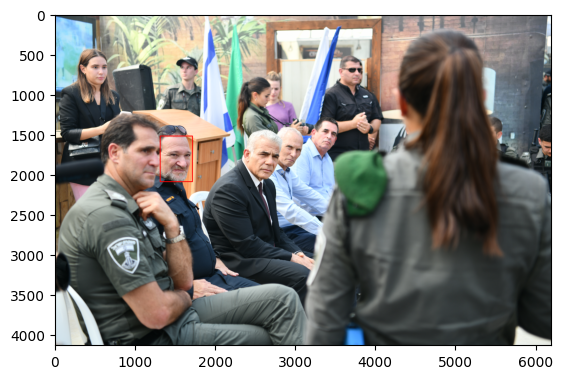

In [169]:
hit = res['hits']['hits'][2]['_source']
src_image = cv2.imread(hit['filename'])
target_position = hit['face_position']

np.savetxt('hit.em', hit['face_embeddings'])

print(hit['filename'])
modified_image = mark_image(src_image, [target_position])
plt.imshow(modified_image)